We can import a scene with the .load function of raillabel, by providing the .json file.

In [1]:
import raillabel
from plyfile import PlyData, PlyElement
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import cv2
from scipy.spatial.transform import Rotation 

In [2]:
learning_map = {
            'background':         0,
            'person':             1,
            'crowd':              1,
            'train':              2,
            'wagons':             2,
            'bicycle':            0,
            'group_of_bicycles':  0,
            'motorcycle':         0,
            'road_vehicle':       3,
            'animal':             0,
            'group_of_animals':   0,
            'wheelchair':         0,
            'drag_shoe':          0,
            'track':              4,
            'transition':         4,
            'switch':             4,
            'catenary_pole':      5,
            'signal_pole':        6,
            'signal':             6,
            'signal_bridge':      0,
            'buffer_stop':        7,
            'flame':              0,
            'smoke':              0
        }
color_map = {#ignore_index:[211, 211, 211],
            0:[211, 211, 211],
            1: [255, 0, 0],  # Person -> Red
            2: [255, 215, 0],# Train -> Yellow
            3: [0, 139, 139],# Road vehicle -> Dark blue
            4: [255, 0, 255],# Track -> Pink
            5: [255, 140, 0],# Catenary_pole -> Orange
            6: [0, 191, 255],# Signal -> Flash blue
            7: [186, 85, 211],# Buffer stop -> Purple
            }

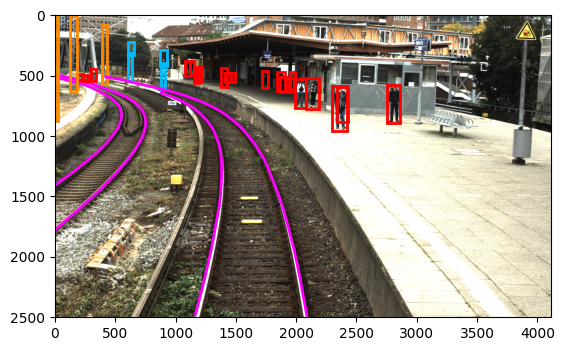

In [3]:

image_path = "/workspaces/baseline/data/OSDaR_dataset/v_2/2_station_berliner_tor_2.1/rgb_highres_center/250_1631531385.100000031.png"
pcd_path = ""

frame_image = cv2.imread(image_path)
image_path = Path(image_path)
scene_path = Path(image_path).parents[1] # Obtain .json file containing label for the current scene
label_file = scene_path / (str(scene_path.name)+"_labels.json")

with open("/workspaces/baseline/data/OSDaR_dataset/v_2/2_station_berliner_tor_2.1/lidar/250_1631531385.099957000.pcd", "r") as b:
    pcd_coord = np.loadtxt(b, skiprows=11, usecols=(0,1,2))

fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))

polygons_list = []
segment = np.full(len(pcd_coord), 0) # Array containing the labels for each point ->first filled with the background tag

if os.path.exists(label_file):
    scene = raillabel.load(label_file) # Load json annotations for scene
    frame_nb = int(image_path.name.split('_')[0]) # returns the frame number as int '037'-> 37 

    scene_filtered = raillabel.filter(scene,include_annotation_types=['poly2d','bbox','seg3d'], include_frames=[frame_nb], include_sensors=['rgb_highres_center','lidar'])

    if frame_nb in scene_filtered.frames: # One of the point cloud doesnt have any frame annotation
        frame_objects = scene_filtered.frames[frame_nb].annotations.keys()
        
        for object in frame_objects:  
            curr_annotation = scene_filtered.frames[frame_nb].annotations[object]

            object_type = curr_annotation.object.type
            annotation_type = type(curr_annotation).__name__

            poly2d_points = []
            if annotation_type == "Poly2d":
                for i in range(len(curr_annotation.points)):
                    poly2d_points.append(curr_annotation.points[i].asdict())
                    #poly2d_points.append(tuple(curr_annotation.points[i].asdict()))
            
                closed_flag = curr_annotation.closed

            elif annotation_type=="Bbox":
                c_u, c_v = curr_annotation.pos.asdict()
                W, H = curr_annotation.size.asdict()
                poly2d_points.append([c_u-W/2, c_v-H/2]) #Top left
                poly2d_points.append([c_u+W/2, c_v-H/2]) #Top right
                poly2d_points.append([c_u+W/2, c_v+H/2]) #Bottom right
                poly2d_points.append([c_u-W/2, c_v+H/2]) #Bottom left
                
                closed_flag = True

            elif annotation_type=="Seg3d":
                pts_idx = scene_filtered.frames[frame_nb].annotations[object].point_ids # Points index for the object
                label_name = scene_filtered.frames[frame_nb].annotations[object].object.type # Object type name ('track','train'...)
                label_number = learning_map[label_name]#labels_dict[label_name] # Map name to tag ('person' -> 1, ...)
                segment[pts_idx] = label_number   # Switch corresponding points with the class number


            if annotation_type in ["Poly2d", "Bbox"]:
                polygons_list.append({"points":poly2d_points, "closed":closed_flag, "classification":object_type})
                polygon = patches.Polygon(poly2d_points, closed=closed_flag, 
                                        edgecolor = [x/256 for x in color_map[learning_map[object_type]] ], fill=False, linewidth=2)

                ax.add_patch(polygon)
        
    else:
        pass # Keep all points of the point cloud as ignore_index

#plt.show()

In [4]:
pcd_coord

array([[  0.20520139,  -1.33803785,  -0.15923573],
       [  0.36920807,  -1.34199941,  -0.14699203],
       [  0.53156108,  -1.34609246,  -0.13096829],
       ...,
       [-13.2013588 ,  30.73007011,   1.8252821 ],
       [ -4.67934561,  10.89995575,   0.94161826],
       [ -4.56256294,  10.63018322,   0.74890339]])

In [5]:
scene.sensors["rgb_left"]

Sensor(uid='rgb_left', extrinsics=Transform(pos=Point3d(x=0.0298925, y=0.186612, z=2.05637), quat=Quaternion(x=0.00228435, y=-0.0104673, z=0.173904, w=0.984704)), intrinsics=IntrinsicsPinhole(camera_matrix=(4622.041473915607, 0.0, 1233.380196060109, 0.0, 0.0, 4622.041473915607, 843.3909933480334, 0.0, 0.0, 0.0, 1.0, 0.0), distortion=(-0.0868757, 0.53867, 0.0, 0.0, 1.69009), width_px=2464, height_px=1600), type=<SensorType.CAMERA: 'camera'>, uri='rgb_left', description=None)

In [6]:
sensor_data = scene.sensors["rgb_highres_center"]#scene_filtered.sensors["rgb_highres_center"]

translation = np.array(sensor_data.extrinsics.pos.asdict()).reshape(3,1)
quaternion = sensor_data.extrinsics.quat.asdict()
camera_mat = np.array(sensor_data.intrinsics.camera_matrix).reshape(3,4)
distortion = sensor_data.intrinsics.distortion
width = sensor_data.intrinsics.width_px
height = sensor_data.intrinsics.height_px


In [7]:
sensor_data

Sensor(uid='rgb_highres_center', extrinsics=Transform(pos=Point3d(x=0.0801578, y=-0.332862, z=3.50982), quat=Quaternion(x=-0.00313306, y=0.0562995, z=0.00482918, w=0.998397)), intrinsics=IntrinsicsPinhole(camera_matrix=(7267.95450880415, 0.0, 2056.049238502414, 0.0, 0.0, 7267.95450880415, 1232.862908875167, 0.0, 0.0, 0.0, 1.0, 0.0), distortion=(-0.0764891, -0.188057, 0.0, 0.0, 1.78279), width_px=4112, height_px=2504), type=<SensorType.CAMERA: 'camera'>, uri='rgb_highres_center', description=None)

In [78]:
hom_pcd_coord = np.r_[pcd_coord.T, np.ones((1,len(pcd_coord)))]

In [79]:
intrinsics_undistorted, _ = cv2.getOptimalNewCameraMatrix(camera_mat[:,:-1], distortion, (width,height), 1, (width,height))
intrinsics_undistorted = np.hstack((intrinsics_undistorted, np.asarray([[0.0], [0.0], [0.0]])))

rotation = Rotation.from_quat(quaternion)
coord_system_rot = Rotation.from_euler('zxy', [-90, 0, 90], degrees=True)
rotation = (rotation * coord_system_rot).as_matrix()

extrinsic = np.vstack((np.hstack((rotation.T, - rotation.T @ translation)), [0.0,0.0,0.0,1.0]))
projection = np.matmul(intrinsics_undistorted, extrinsic)

points_2d = np.matmul(projection, hom_pcd_coord)

In [80]:
# divide x by z if z is not 0
points_2d[0,:] = np.divide(points_2d[0,:],points_2d[2,:],where=points_2d[2,:]!=0)
# divide y by z if z is not 0
points_2d[1,:] = np.divide(points_2d[1,:],points_2d[2,:],where=points_2d[2,:]!=0)

In [81]:
image_coordinates =points_2d[:2,:].T

In [49]:
# from scipy.spatial.transform import Rotation 

In [75]:
image_coordinates

array([[ 2.66396791e+03, -2.39904449e+03],
       [ 3.02562725e+03, -2.41989283e+03],
       [ 3.38805599e+03, -2.44200897e+03],
       ...,
       [-3.88636536e+08,  8.95804855e+08],
       [-1.93607034e+06,  4.46431123e+06],
       [-2.19004486e+06,  5.02641214e+06]])

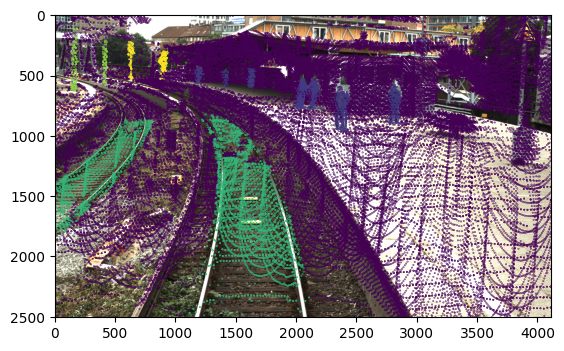

In [82]:
# frame_image = cv2.imread(image_path)
plt.close("all")
fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
# plt.plot(image_coordinates[:,0],image_coordinates[:,1],"o")#, c=segment)
# ax = plt.gca()
ax.set_xlim([0, width])
ax.set_ylim([0, height])
# # # ax.set_xlim([-width/2, width/2])
# # # ax.set_ylim([-height/2, height/2])
ax.scatter(image_coordinates[:,0],image_coordinates[:,1], c=segment,s=0.1)#pcd_coord[:,0])

# for i, txt in enumerate(pcd_coord[:,1]):
#     ax.annotate(round(txt,1), (image_coordinates[:,0][i], image_coordinates[:,1][i]))
plt.gca().invert_yaxis()
plt.show()

In [9]:
points_3d_camera = Rotation.from_quat(quaternion).apply(pcd_coord)+translation
points_2d_hom = np.reshape(camera_mat,(3,4)) [:,:3]@points_3d_camera.T
pixel=points_2d_hom[:2]/points_2d_hom[2]
image_coordinates=pixel.T

In [204]:
pixel.T

array([[  2665.00897885,  -2405.2641706 ],
       [  3024.92194363,  -2417.23570263],
       [  3381.95531213,  -2425.17781546],
       ...,
       [-12341.85182034,  34419.71612375],
       [ -4713.08786725,  16820.69532393],
       [ -4855.26898989,  17076.39140876]])

In [176]:
segment.shape

(191895,)

In [175]:
image_coordinates.shape

(191895, 2)

In [140]:
curr_annotation.sensor.intrinsics

IntrinsicsPinhole(camera_matrix=(7267.95450880415, 0.0, 2056.049238502414, 0.0, 0.0, 7267.95450880415, 1232.862908875167, 0.0, 0.0, 0.0, 1.0, 0.0), distortion=(-0.0764891, -0.188057, 0.0, 0.0, 1.78279), width_px=4112, height_px=2504)

In [87]:
scene_filtered

Scene(metadata=Metadata(schema_version='1.0.0', annotator='FusionSystems GmbH (Chemnitz, Germany), on behalf of the German Centre for Rail Traffic Research (Germany, www.dzsf.bund.de) and in cooperation with Digitale Schiene Deutschland / DB Netz AG (Germany)', comment='The Open Sensor Data for Rail 2023 (OSDaR23, https://doi.org/10.57806/9mv146r0) is published by the German Centre for Rail Traffic Research at the Federal Railway Authority (DZSF, https://www.dzsf.bund.de). Annotation data (file type .json) are published under CC0 1.0 (https://creativecommons.org/publicdomain/zero/1.0/legalcode). Sensor data (file types .png, .pcd, and .csv) are published under CC BY-SA 3.0 de (https://creativecommons.org/licenses/by-sa/3.0/de/legalcode).', exporter_version='3.1', file_version='1.2.0', name="sequence #1 'calibration' / part 1.1", subschema_version='3.0.0', tagged_file='1_calibration_1.1'), sensors={'rgb_highres_center': Sensor(uid='rgb_highres_center', extrinsics=Transform(pos=Point3d(x

In [81]:
polygons_list[0]

{'points': [[953.2566423138537, 307.07083143472073],
  [966.8419823958218, 307.07083143472073],
  [966.8419823958218, 472.03359891418427],
  [953.2566423138537, 472.03359891418427]],
 'closed': True,
 'classification': 'catenary_pole'}

In [71]:
scene_filtered.frames[12].annotations["17eb249a-bd32-4a67-9539-144de28e0b4b"].closed

False

In [ ]:
json_path = '/workspaces/baseline/data/OSDaR_dataset/original/1_calibration_1.1/1_calibration_1.1_labels.json'

In [2]:
scene = raillabel.load(json_path)

Let's load all the objects that are in frame 12, are of type poly2d and are from the rgb center frame

In [5]:
polygon = raillabel.filter(scene,include_annotation_types=['poly2d'],include_frames=[12], include_sensors=['rgb_center'])

1_calibration_1.1_12
[(887.1041666666667, 1325.1335417150817), (1147.4746297676602, 1220.854608984207), (1467.8125, 1299.4650953864605), (1585.9979258476644, 1599.0), (861.8710571836388, 1599.0)]
[(0.0, 1240.4870942409523), (88.40613932324658, 1200.6506490715801), (180.1659925364461, 1154.6884942669392), (351.1400304951054, 1065.2110310137605), (695.5326936364534, 892.0335295668281)]
[(0.0, 1483.506025405132), (338.07630805248056, 1212.4127548795411), (721.8083553111343, 899.2698533970791)]
[(717.6413327816032, 859.1410002498429), (729.9848327816031, 859.1410002498429), (729.9848327816031, 869.0056722498429), (717.6413327816032, 869.0056722498429)]
[(818.4981546939321, 859.7333167131084), (830.014529693932, 859.7333167131084), (830.014529693932, 868.7603887131085), (818.4981546939321, 868.7603887131085)]
[(1029.9830837341804, 860.4058247807858), (1040.1490837341805, 860.4058247807858), (1040.1490837341805, 868.2103277807859), (1029.9830837341804, 868.2103277807859)]
[(1577.313008039107

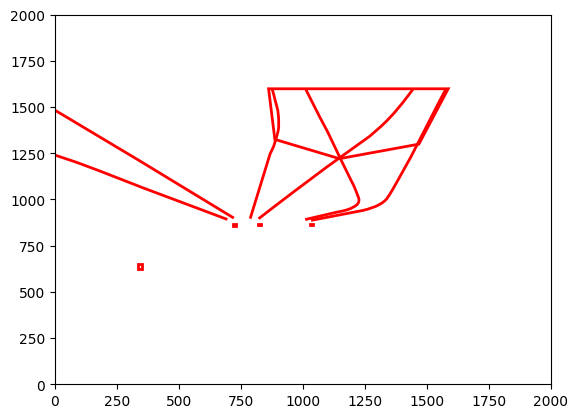

In [6]:


scene_poly2d_filtered = raillabel.filter(scene, include_annotation_types=['poly2d'], include_sensors=['rgb_center'])
scene_name  = scene_poly2d_filtered.metadata.tagged_file

for frame in scene_poly2d_filtered.frames.keys():
    #Create new row for the frame, with all values set to 0.
    frame_name = scene_name + '_'+ str(frame)
    print(frame_name)
    # df.loc[frame_name] = list(np.zeros(len(df.columns))) 
    fig, ax = plt.subplots()
    for annotation in scene_poly2d_filtered.frames[frame].annotations.keys():
        object_type = scene_poly2d_filtered.frames[frame].annotations[annotation].object.type
        poly2d_points = []
        for i in range(len(scene_poly2d_filtered.frames[frame].annotations[annotation].points)):
            poly2d_points.append(tuple(scene_poly2d_filtered.frames[frame].annotations[annotation].points[i].asdict()))
        #nb_points = len(scene_poly2d_filtered.frames[frame].annotations[annotation].poly2d)
        print(poly2d_points)
        # Create plot
        
        #ax.imshow(image)
        closed_flag = scene_poly2d_filtered.frames[frame].annotations[annotation].closed
        # Create polygon patch
        polygon = patches.Polygon(poly2d_points, closed=closed_flag, edgecolor='red', fill=False, linewidth=2)

        ax.add_patch(polygon)
    ax.set_xlim([0,2000])
    ax.set_ylim([0,2000])
    plt.show()
        #break
    break

    #     # Update number of point and annotations for this type of object.
    #     df.loc[frame_name, object_type + '_nb_points'] += nb_points 
    #     df.loc[frame_name, object_type + '_nb_annotations'] += 1

In [42]:
polygon.objects

{'29f8d6c6-71fe-4aa5-8910-4eb5e967cba7': Object(uid='29f8d6c6-71fe-4aa5-8910-4eb5e967cba7', name='switch0001', type='switch'),
 '6a6fc687-5b65-4dc3-833c-def82c7ffbb0': Object(uid='6a6fc687-5b65-4dc3-833c-def82c7ffbb0', name='track0001', type='track'),
 '901c694e-c51c-458c-b94a-783e05d49d9c': Object(uid='901c694e-c51c-458c-b94a-783e05d49d9c', name='signal0001', type='signal'),
 '97cdc3bd-7e68-4c28-b779-b2ba3e1384b8': Object(uid='97cdc3bd-7e68-4c28-b779-b2ba3e1384b8', name='signal0002', type='signal'),
 'c032d5ab-5b82-45c6-add8-8a82d1c23eaf': Object(uid='c032d5ab-5b82-45c6-add8-8a82d1c23eaf', name='signal0003', type='signal'),
 'cc855fd5-da10-4317-b7f8-a58f4f8ef04e': Object(uid='cc855fd5-da10-4317-b7f8-a58f4f8ef04e', name='track0003', type='track'),
 'f5b369d2-8dd3-473e-ba8b-cb5eef1b3425': Object(uid='f5b369d2-8dd3-473e-ba8b-cb5eef1b3425', name='track0002', type='track'),
 'fb5c3c62-9f9e-46d1-98a5-d0561c408f16': Object(uid='fb5c3c62-9f9e-46d1-98a5-d0561c408f16', name='signal0004', type='

In [7]:
polygon_and_bbox = raillabel.filter(scene,include_annotation_types=['poly2d', "bbox"] ,include_frames=[12], include_sensors=['rgb_center'])

In [22]:
polygon_and_bbox.frames[12].annotations['81175aef-780f-4c25-a06f-537953feb2a7'].pos


Point2d(x=807.1379535424494, y=877.0382150276109)